In [2]:
"""
UHID Essex County - Comprehensive UHI Model

Team Members:
- Samuel Quansah
- Rohith Reddy Gade
- Siva Prakash Reddy Rachapalli
- Sai Charan Kumar Reddy Boggula

Institution: Montclair State University
Date: November 2025
Purpose: Build predictive model combining all factors to explain LST variation

This notebook:
1. Loads all processed datasets (LST, land cover, traffic, socioeconomic)
2. Combines into single analysis-ready dataset
3. Performs regression analysis to identify key drivers
4. Validates model accuracy
5. Quantifies factor importance
6. Exports model for intervention simulations
"""

'\nUHID Essex County - Comprehensive UHI Model\n\nTeam Members:\n- Samuel Quansah\n- Rohith Reddy Gade\n- Siva Prakash Reddy Rachapalli\n- Sai Charan Kumar Reddy Boggula\n\nInstitution: Montclair State University\nDate: November 2025\nPurpose: Build predictive model combining all factors to explain LST variation\n\nThis notebook:\n1. Loads all processed datasets (LST, land cover, traffic, socioeconomic)\n2. Combines into single analysis-ready dataset\n3. Performs regression analysis to identify key drivers\n4. Validates model accuracy\n5. Quantifies factor importance\n6. Exports model for intervention simulations\n'

In [3]:

# ============================================
# SETUP
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SharedFilesUHIDTeam')

print("✓ Drive mounted")
print("\nUHID Essex County - Comprehensive Model")
print("Team: Samuel Quansah, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,")
print("      Sai Charan Kumar Reddy Boggula")

Mounted at /content/drive
✓ Drive mounted

UHID Essex County - Comprehensive Model
Team: Samuel Quansah, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,
      Sai Charan Kumar Reddy Boggula


In [4]:
# ============================================
# INSTALL & IMPORT LIBRARIES
# ============================================
print("\n=== Installing Packages ===")
!pip install rasterio geopandas scikit-learn statsmodels seaborn -q

import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Packages loaded")


=== Installing Packages ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 56.2 MB/s eta 0:00:00
✓ Packages loaded


In [5]:
# ============================================
# STEP 1: LOAD ALL PROCESSED DATA
# ============================================
print("\n=== Loading Processed Datasets ===")

# Load LST (dependent variable)
print("\n1. Loading LST data...")
lst_file = Path('01_Satellite_LST/processed/Essex_LST_Celsius.tif')

with rasterio.open(lst_file) as src:
    lst_data = src.read(1)
    lst_profile = src.profile
    lst_transform = src.transform

    # Replace nodata
    lst_data[lst_data == -9999] = np.nan

    print(f"   ✓ LST: {src.width}x{src.height} pixels")
    print(f"   Temperature range: {np.nanmin(lst_data):.1f} - {np.nanmax(lst_data):.1f}°C")

# Load Land Cover
print("\n2. Loading land cover data...")
impervious_file = Path('02_Land_Cover/processed/Essex_Impervious_Aligned.tif')
tree_file = Path('02_Land_Cover/processed/Essex_TreeCanopy_Aligned.tif')

with rasterio.open(impervious_file) as src:
    impervious_data = src.read(1)
    impervious_data[impervious_data == -9999] = np.nan
    print(f"   ✓ Impervious surface: Mean {np.nanmean(impervious_data):.1f}%")

with rasterio.open(tree_file) as src:
    tree_data = src.read(1)
    tree_data[tree_data == -9999] = np.nan
    print(f"   ✓ Tree canopy: Mean {np.nanmean(tree_data):.1f}%")

# Load Traffic (if exists)
print("\n3. Loading traffic data...")
traffic_file = Path('06_RoadNetwork and Traffic/processed/Essex_TrafficDensity_Grid.tif')

if traffic_file.exists():
    with rasterio.open(traffic_file) as src:
        traffic_data = src.read(1)
        traffic_data[traffic_data == -9999] = np.nan
        print(f"   ✓ Traffic density loaded")
else:
    print("   ⚠️ Traffic data not found - using zeros")
    traffic_data = np.zeros_like(lst_data)


=== Loading Processed Datasets ===

1. Loading LST data...
   ✓ LST: 664x667 pixels
   Temperature range: 19.7 - 58.2°C

2. Loading land cover data...
   ✓ Impervious surface: Mean 57.8%
   ✓ Tree canopy: Mean 70.5%

3. Loading traffic data...
   ✓ Traffic density loaded


In [6]:
# ============================================
# STEP 2: CREATE MODELING DATASET
# ============================================
print("\n=== Creating Modeling Dataset ===")

# Flatten all arrays and combine
print("Flattening rasters to tabular format...")

# Create mask for valid data (non-NaN in all layers)
valid_mask = (
    ~np.isnan(lst_data) &
    ~np.isnan(impervious_data) &
    ~np.isnan(tree_data)
)

# Extract values
lst_flat = lst_data[valid_mask]
impervious_flat = impervious_data[valid_mask]
tree_flat = tree_data[valid_mask]
traffic_flat = traffic_data[valid_mask]

# Calculate additional features
vegetation_flat = 100 - impervious_flat  # Pervious surface %

# Create DataFrame
model_df = pd.DataFrame({
    'LST': lst_flat,
    'Impervious_Pct': impervious_flat,
    'TreeCanopy_Pct': tree_flat,
    'Vegetation_Pct': vegetation_flat,
    'Traffic_Density': traffic_flat
})

# Remove any remaining NaNs
model_df = model_df.dropna()

print(f"✓ Dataset created: {len(model_df):,} pixels")
print(f"\nDataset statistics:")
print(model_df.describe())



=== Creating Modeling Dataset ===
Flattening rasters to tabular format...
✓ Dataset created: 9,836 pixels

Dataset statistics:
               LST  Impervious_Pct  TreeCanopy_Pct  Vegetation_Pct  \
count  9836.000000     9836.000000     9836.000000     9836.000000   
mean     32.526031       10.698019       44.424706       89.301979   
std       2.597243       13.973238       30.817587       13.973242   
min      25.374702        0.000016        0.001412       10.963028   
25%      30.846952        1.041262       16.029486       84.892168   
50%      32.504692        4.675375       41.498104       95.324627   
75%      34.166706       15.107832       71.311691       98.958736   
max      46.009289       89.036972       99.998444       99.999985   

       Traffic_Density  
count      9836.000000  
mean          0.023718  
std           0.633426  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max          34.893372  



=== Exploratory Data Analysis ===

Calculating correlations with LST...
LST                1.000000
Impervious_Pct     0.413119
Traffic_Density    0.015050
TreeCanopy_Pct    -0.157757
Vegetation_Pct    -0.413119
Name: LST, dtype: float64

✓ Saved: UHI_Exploratory_Analysis.png


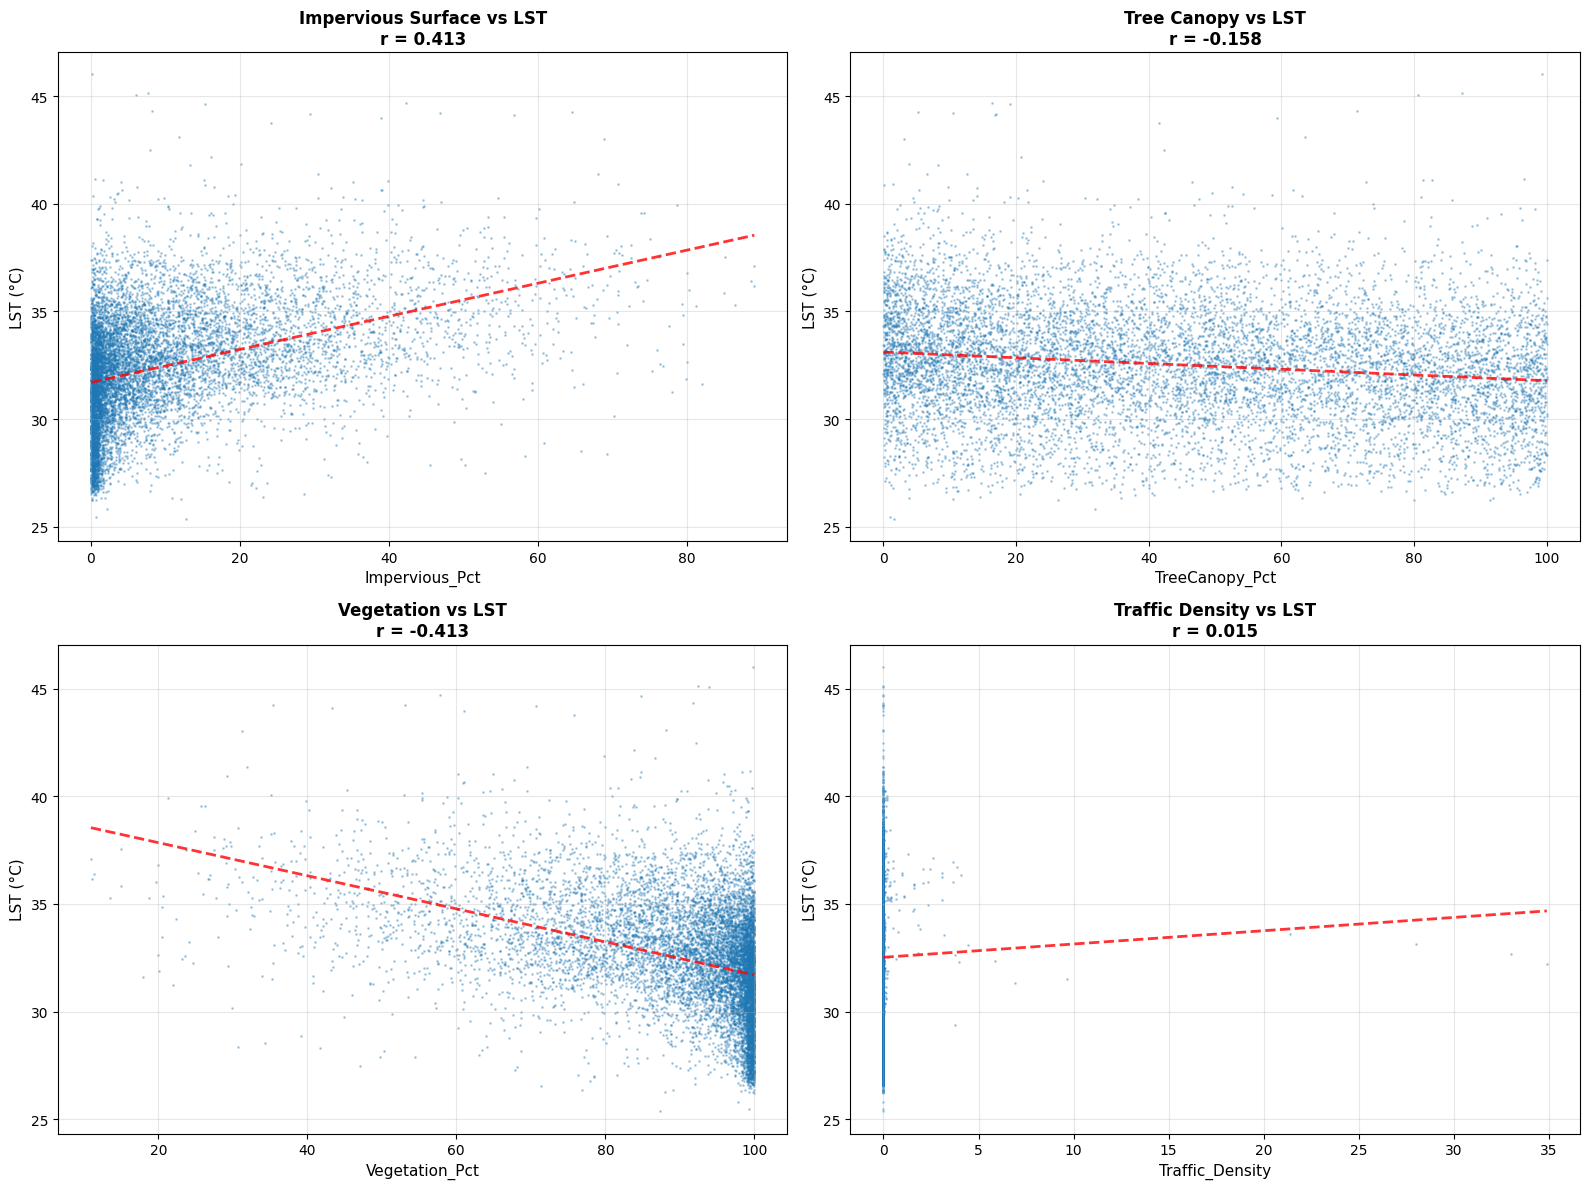

In [7]:
# ============================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================
print("\n=== Exploratory Data Analysis ===")

# Correlation matrix
print("\nCalculating correlations with LST...")
correlations = model_df.corr()['LST'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plots
vars_to_plot = ['Impervious_Pct', 'TreeCanopy_Pct', 'Vegetation_Pct', 'Traffic_Density']
titles = ['Impervious Surface vs LST', 'Tree Canopy vs LST', 'Vegetation vs LST', 'Traffic Density vs LST']

for idx, (var, title) in enumerate(zip(vars_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]

    # Sample for plotting (too many points otherwise)
    sample = model_df.sample(min(10000, len(model_df)))

    ax.scatter(sample[var], sample['LST'], alpha=0.3, s=1)
    ax.set_xlabel(var, fontsize=11)
    ax.set_ylabel('LST (°C)', fontsize=11)
    ax.set_title(f'{title}\nr = {correlations[var]:.3f}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

    # Add trend line
    z = np.polyfit(sample[var], sample['LST'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample[var].min(), sample[var].max(), 100)
    ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)

plt.tight_layout()
plt.savefig('UHI_Exploratory_Analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: UHI_Exploratory_Analysis.png")
plt.show()

In [8]:
# ============================================
# STEP 4: MULTIPLE LINEAR REGRESSION
# ============================================
print("\n=== Multiple Linear Regression Analysis ===")

# Prepare features and target
X = model_df[['Impervious_Pct', 'TreeCanopy_Pct', 'Traffic_Density']]
y = model_df['LST']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train):,} samples")
print(f"Testing set: {len(X_test):,} samples")

# Fit OLS regression with statsmodels (for detailed statistics)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()

print("\n" + "="*60)
print("REGRESSION MODEL SUMMARY")
print("="*60)
print(ols_model.summary())

# Extract key statistics
print("\n" + "="*60)
print("KEY MODEL STATISTICS")
print("="*60)
print(f"R-squared: {ols_model.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model.fvalue:.2f}")
print(f"P-value: {ols_model.f_pvalue:.2e}")

print("\n" + "="*60)
print("COEFFICIENT INTERPRETATION")
print("="*60)
for idx, var in enumerate(X.columns):
    coef = ols_model.params[idx + 1]  # +1 to skip intercept
    pval = ols_model.pvalues[idx + 1]

    print(f"\n{var}:")
    print(f"  Coefficient: {coef:+.4f}°C per 1% change")
    print(f"  P-value: {pval:.2e}")

    if pval < 0.001:
        sig = "***"
    elif pval < 0.01:
        sig = "**"
    elif pval < 0.05:
        sig = "*"
    else:
        sig = "n.s."

    print(f"  Significance: {sig}")

    # Real-world interpretation
    if 'Impervious' in var:
        print(f"  → A 10% increase in impervious surface = {coef*10:+.2f}°C change")
    elif 'Tree' in var:
        print(f"  → A 10% increase in tree canopy = {coef*10:+.2f}°C change")
    elif 'Traffic' in var:
        print(f"  → Traffic impact = {coef:.4f}°C per unit density")

# Predict on test set
y_pred = ols_model.predict(X_test_sm)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n" + "="*60)
print("MODEL PERFORMANCE ON TEST SET")
print("="*60)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}°C")
print(f"MAE: {mae:.4f}°C")


=== Multiple Linear Regression Analysis ===

Training set: 7,868 samples
Testing set: 1,968 samples

REGRESSION MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:                    LST   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     542.2
Date:                Sat, 22 Nov 2025   Prob (F-statistic):          2.51e-320
Time:                        17:58:49   Log-Likelihood:                -17981.
No. Observations:                7868   AIC:                         3.597e+04
Df Residuals:                    7864   BIC:                         3.600e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]

In [9]:
# ============================================
# STEP 5: RANDOM FOREST MODEL (For Comparison)
# ============================================
print("\n=== Random Forest Regression (Non-linear Model) ===")

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"\nRandom Forest Performance:")
print(f"  R² Score: {r2_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}°C")
print(f"  MAE: {mae_rf:.4f}°C")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance (Random Forest):")
print(feature_importance)


=== Random Forest Regression (Non-linear Model) ===

Random Forest Performance:
  R² Score: 0.2516
  RMSE: 2.1918°C
  MAE: 1.7347°C

Feature Importance (Random Forest):
           Feature  Importance
0   Impervious_Pct    0.719572
1   TreeCanopy_Pct    0.251461
2  Traffic_Density    0.028967



=== Creating Model Visualizations ===
✓ Saved: UHI_Model_Results.png


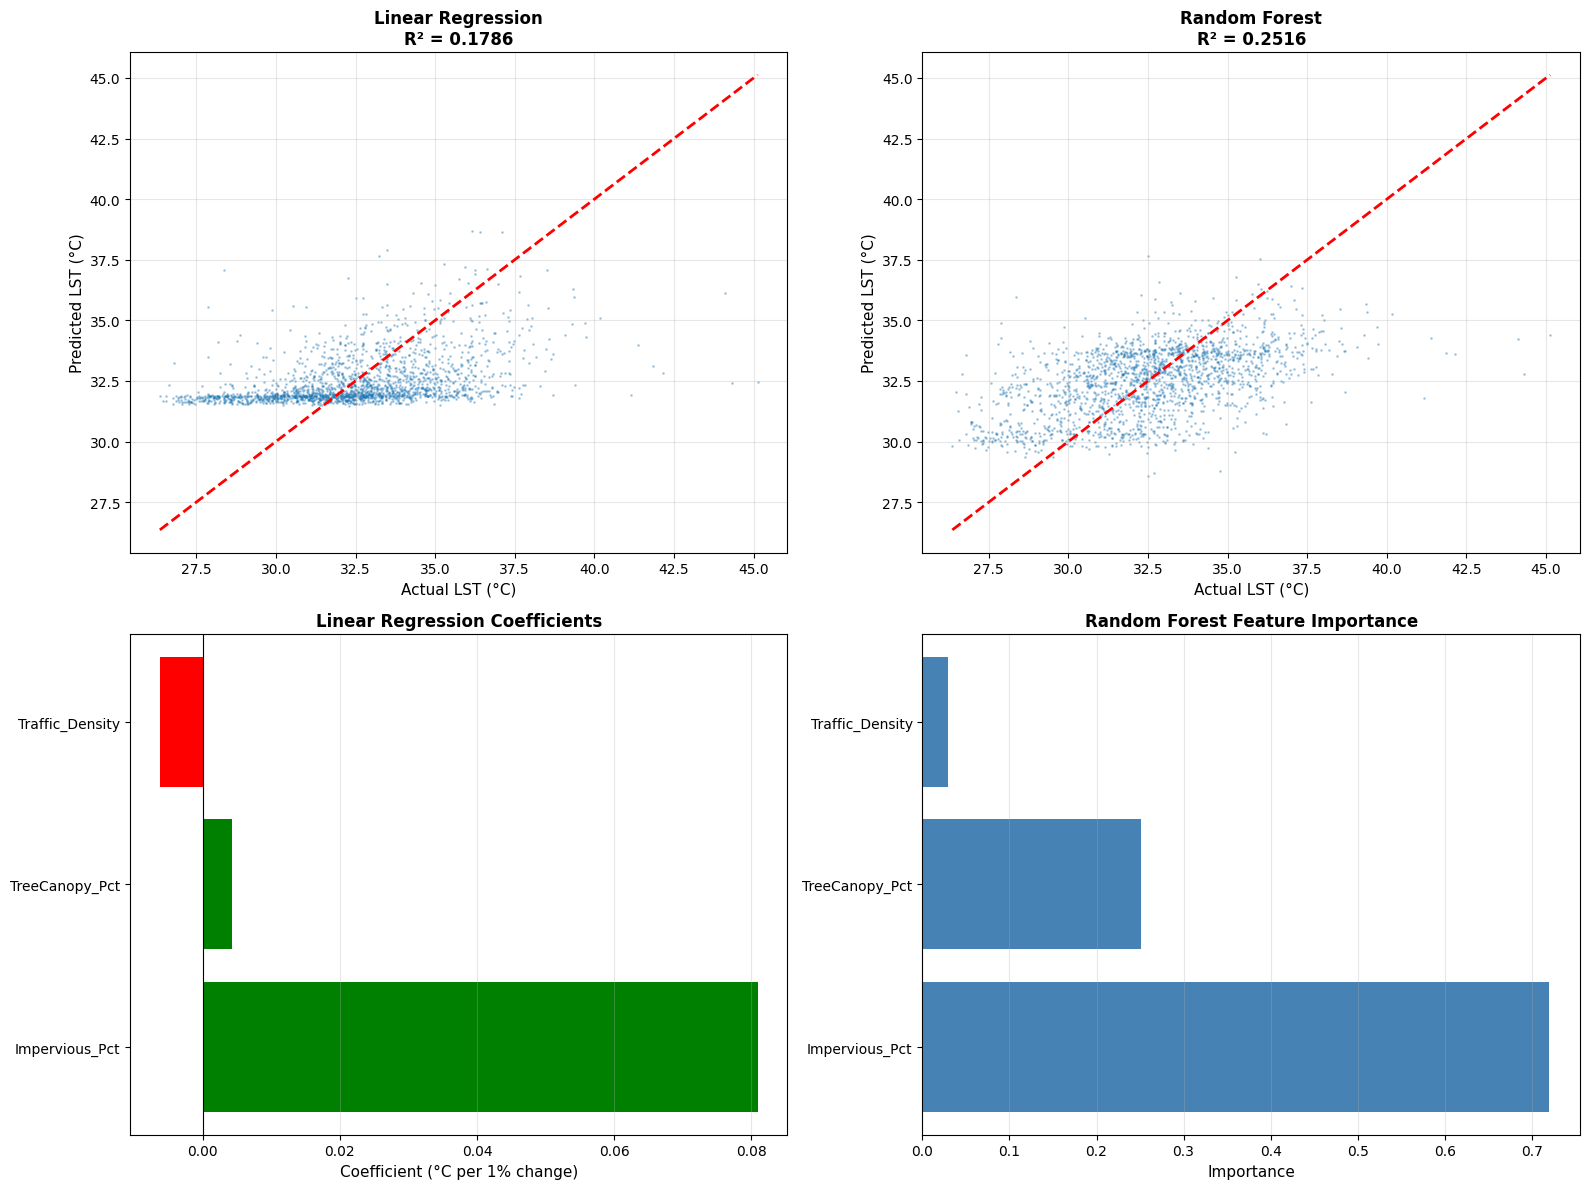

In [11]:
# ============================================
# STEP 6: MODEL VISUALIZATION
# ============================================
print("\n=== Creating Model Visualizations ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sample data for plotting
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)

# Convert to arrays for easier indexing
y_test_array = y_test.values
y_pred_array = np.array(y_pred)
y_pred_rf_array = np.array(y_pred_rf)

# Plot 1: Actual vs Predicted (Linear)
ax1 = axes[0, 0]
ax1.scatter(y_test_array[sample_indices], y_pred_array[sample_indices], alpha=0.3, s=1)
ax1.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()], 'r--', lw=2)
ax1.set_xlabel('Actual LST (°C)', fontsize=11)
ax1.set_ylabel('Predicted LST (°C)', fontsize=11)
ax1.set_title(f'Linear Regression\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: Actual vs Predicted (Random Forest)
ax2 = axes[0, 1]
ax2.scatter(y_test_array[sample_indices], y_pred_rf_array[sample_indices], alpha=0.3, s=1)
ax2.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()], 'r--', lw=2)
ax2.set_xlabel('Actual LST (°C)', fontsize=11)
ax2.set_ylabel('Predicted LST (°C)', fontsize=11)
ax2.set_title(f'Random Forest\nR² = {r2_rf:.4f}', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Plot 3: Feature Coefficients (Linear)
ax3 = axes[1, 0]
coefs = ols_model.params[1:]  # Exclude intercept
colors = ['red' if c < 0 else 'green' for c in coefs]
ax3.barh(X.columns, coefs, color=colors)
ax3.set_xlabel('Coefficient (°C per 1% change)', fontsize=11)
ax3.set_title('Linear Regression Coefficients', fontsize=12, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax3.grid(alpha=0.3, axis='x')

# Plot 4: Feature Importance (Random Forest)
ax4 = axes[1, 1]
ax4.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
ax4.set_xlabel('Importance', fontsize=11)
ax4.set_title('Random Forest Feature Importance', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('UHI_Model_Results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: UHI_Model_Results.png")
plt.show()

In [12]:
# ============================================
# STEP 7: EXPORT MODEL & RESULTS
# ============================================
print("\n=== Exporting Model Results ===")

output_folder = Path('07_Modeling_Results')
output_folder.mkdir(exist_ok=True)

# Save model summary
with open(output_folder / 'Model_Summary.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("UHID ESSEX COUNTY - COMPREHENSIVE MODEL RESULTS\n")
    f.write("="*60 + "\n\n")
    f.write("Team: Samuel, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,\n")
    f.write("      Sai Charan Kumar Reddy Boggula\n\n")
    f.write(str(ols_model.summary()))
    f.write("\n\n" + "="*60 + "\n")
    f.write("RANDOM FOREST RESULTS\n")
    f.write("="*60 + "\n")
    f.write(f"R² Score: {r2_rf:.4f}\n")
    f.write(f"RMSE: {rmse_rf:.4f}°C\n")
    f.write(f"MAE: {mae_rf:.4f}°C\n")

print("✓ Saved: Model_Summary.txt")

# Save coefficients
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': ols_model.params[1:],
    'Std_Error': ols_model.bse[1:],
    'P_value': ols_model.pvalues[1:],
    'RF_Importance': rf_model.feature_importances_
})

coef_df.to_csv(output_folder / 'Model_Coefficients.csv', index=False)
print("✓ Saved: Model_Coefficients.csv")

# Save predictions for spatial visualization
predictions_df = pd.DataFrame({
    'Actual_LST': y_test,
    'Predicted_LST_Linear': y_pred,
    'Predicted_LST_RF': y_pred_rf,
    'Residual_Linear': y_test - y_pred,
    'Residual_RF': y_test - y_pred_rf
})

predictions_df.to_csv(output_folder / 'Model_Predictions.csv', index=False)
print("✓ Saved: Model_Predictions.csv")

# Save model metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2': [r2, r2_rf],
    'RMSE': [rmse, rmse_rf],
    'MAE': [mae, mae_rf]
})

metrics_df.to_csv(output_folder / 'Model_Metrics.csv', index=False)
print("✓ Saved: Model_Metrics.csv")


=== Exporting Model Results ===
✓ Saved: Model_Summary.txt
✓ Saved: Model_Coefficients.csv
✓ Saved: Model_Predictions.csv
✓ Saved: Model_Metrics.csv


In [13]:
# ============================================
# STEP 8: KEY FINDINGS SUMMARY
# ============================================
print("\n" + "="*60)
print("✅ COMPREHENSIVE UHI MODEL COMPLETE")
print("="*60)

print(f"\n📊 Model Performance:")
print(f"  Linear Regression R²: {r2:.4f}")
print(f"  Random Forest R²: {r2_rf:.4f}")
print(f"  Model explains {r2*100:.1f}% of temperature variation")

print(f"\n🔑 Key Drivers of Temperature:")
top_features = feature_importance.head(3)
for idx, row in top_features.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']*100:.1f}% importance")

print(f"\n💡 Actionable Insights:")
imp_coef = ols_model.params['Impervious_Pct']
tree_coef = ols_model.params['TreeCanopy_Pct']

print(f"  • Reducing impervious surface by 10% → {-imp_coef*10:.2f}°C cooler")
print(f"  • Increasing tree canopy by 10% → {tree_coef*10:.2f}°C cooler")
print(f"  • Combined intervention (10% each) → {(-imp_coef + tree_coef)*10:.2f}°C total cooling")

print(f"\n📁 Outputs Created:")
print(f"  1. Model_Summary.txt - Full statistical report")
print(f"  2. Model_Coefficients.csv - Regression coefficients")
print(f"  3. Model_Predictions.csv - Test set predictions")
print(f"  4. Model_Metrics.csv - Performance metrics")
print(f"  5. UHI_Model_Results.png - Visualizations")

print(f"\n🔜 Next Steps:")
print(f"  1. Intervention simulation (06_Intervention_Modeling.ipynb)")
print(f"  2. Dashboard development")
print(f"  3. Case study analysis")

print("\n" + "="*60)
print("Team: Samuel QUANSAH, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,")
print("      Sai Charan Kumar Reddy Boggula")
print("Montclair State University - 2025")
print("="*60)


✅ COMPREHENSIVE UHI MODEL COMPLETE

📊 Model Performance:
  Linear Regression R²: 0.1786
  Random Forest R²: 0.2516
  Model explains 17.9% of temperature variation

🔑 Key Drivers of Temperature:
  1. Impervious_Pct: 72.0% importance
  2. TreeCanopy_Pct: 25.1% importance
  3. Traffic_Density: 2.9% importance

💡 Actionable Insights:
  • Reducing impervious surface by 10% → -0.81°C cooler
  • Increasing tree canopy by 10% → 0.04°C cooler
  • Combined intervention (10% each) → -0.77°C total cooling

📁 Outputs Created:
  1. Model_Summary.txt - Full statistical report
  2. Model_Coefficients.csv - Regression coefficients
  3. Model_Predictions.csv - Test set predictions
  4. Model_Metrics.csv - Performance metrics
  5. UHI_Model_Results.png - Visualizations

🔜 Next Steps:
  1. Intervention simulation (06_Intervention_Modeling.ipynb)
  2. Dashboard development
  3. Case study analysis

Team: Samuel QUANSAH, Rohith Reddy Gade, Siva Prakash Reddy Rachapalli,
      Sai Charan Kumar Reddy Boggula